## TO DO - Aug 26th
* write all plotting functions
* add number of timepoints for each patients on graph
* do EDA for: 
    * UPDRS with average
    * Non-motor assessments
    * Gen Medical info
    * Neurological assessements
* to plot as well: unbalance of class in the dataset using an histogram

## REFERENCES

* **Data viz - Jesus**: 
 > http://localhost:8888/notebooks/00_TRAINING/02_DSR/VIZ_course/PLOTLY/code_for_slides.ipynb
 > http://localhost:8888/notebooks/01_Dev/02_Python-tutorials_Jupyter-notebooks/03_Python_forDS_Udemy/Plotly%20and%20cufflinks_AM.ipynb

### Specific to time-series: 
* https://github.com/ChadFulton/tsa-notebooks
* https://github.com/maxim5/time-series-machine-learning

### time-series w/ DL on EHR data
* https://github.com/AMDonati/Deep-Neural-Networks-HealthCare/tree/master/Project%209%20--%20Deep%20Learning%20RNN%20for%20Predicting%20%20Glucose%20Concentration%20for%20Diabetes1%20Patients
* https://github.com/AMDonati/Deep-Neural-Networks-HealthCare/tree/master/Project%209%20--%20Deep%20Learning%20RNN%20for%20Predicting%20%20Glucose%20Concentration%20for%20Diabetes1%20Patients
* https://github.com/AMDonati/doctorai

### Kaggle Kernels
* https://www.kaggle.com/c/web-traffic-time-series-forecasting

## 0. Imports & functions

In [1]:
#imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.plotly as py
import cufflinks as cf
import seaborn as sns
import urllib.parse
from glob import glob
import os
import ntpath 
import zipfile
from datetime import datetime

#and enable the offline mode in the notebook (not needed in Jupyter Lab)
#py.offline.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

PPMI_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/'

In [2]:
#!pip install cufflinks --upgrade

In [3]:
def reading_csv_files(folder_path):
    # saving all the csv files in a dataframe
    import os
    import glob
    # glob.glob('*.csv') #find all the csv files in a pathname. 
    os.chdir(folder_path)
    csv_files = [i for i in glob.glob('*.csv')]

    # Reading each csv file and storing them in a dictionnary containing the file name and the dataframe
    dict_files={}
    files_names=[]
    for files in csv_files:
        df=pd.read_csv(files,engine='python')
        basepath, filename=ntpath.split(files)
        files_names.append(filename)
        dict_files[filename]=df
        
    # Calculating the # of rows and features for each dataframe and storing them in a list of tuples
    shape_df=[]
    for i in range(0,len(dict_files.keys())):
        nrows, ncols=(len(dict_files[files_names[i]]),len(dict_files[files_names[i]].columns))
        shape_df.append((nrows,ncols))

    return (shape_df,files_names,dict_files)

In [4]:
def number_of_patients(df):
    '''return the number of patients in each csv files and the number of events'''
    patients=len(list(set(df['PATNO'])))
    if 'EVENT_ID' in df.columns:
        events=len(list(set(df['EVENT_ID'])))
    else:
        events='no TS data'
    return (patients,events)

In [5]:
def features_selection(df, SEL):
    '''cleanier way to do features selection in each csv file'''
    return df_sel

In [6]:
def patients_selection(df, threshold=6):
    '''return a dataframe containing only the patients with number of visits > threshold'''
    if 'PATNO' in df.columns: 
        visits_number_by_pat=df.groupby('PATNO').size().sort_values(ascending=False)
        mask_sel=visits_number_by_pat>=threshold
        patients_sel=list(mask_sel[mask_sel.values==True].index)
        df=df.loc[df['PATNO'].isin(patients_sel),:]
        df=df.sort_values('PATNO')
        return (patients_sel, df)
    else:
        print("There is no 'PATNO' column in the dataframe")

In [7]:
def patients_sampling(df,sample_size=25,seed=123):
    np.random.seed(seed)
    sample=list(np.random.randint(0,number_of_patients(diagfeat_EADL)[0],sample_size+1))
    patients_sample=pd.Series(list(set(df['PATNO'])))[sample]
    patients_sample=list(patients_sample.values)
    sub_df=df.loc[diagfeat_EADL['PATNO'].isin(patients_sample),:]
    return sub_df

In [8]:
def INFODT_date(df):
    if 'INFODT' in df.columns: 
        df['INFODT_date']=df['INFODT'].apply(lambda x: datetime.strptime(x,'%m/%Y'))
    return df

In [10]:
def plotting(df,sample_size=25):
        '''EDA on features'''
# first plot 
sns.set(style="darkgrid")
g = sns.FacetGrid(sub_df, col="PATNO", margin_titles=True,col_wrap=5)
g.map(plt.hist, "sum_feat", color="steelblue")

# second plot
g = sns.FacetGrid(sub_df, col="PATNO", margin_titles=True,col_wrap=5)
g.map(plt.plot, "sum_feat", color="steelblue")

# third plot
ax=sns.boxplot(y="sum_feat",
            x="PATNO", data=sub_df)
ax.figure.set_size_inches(w=20,h=10)

In [11]:
def feat_variance_analysis(df,sample_size=25): 
    ''''''

## 1. Data-processing

###  Getting the PD people.


In [12]:
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/1-Subject-Characteristics/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### Patient_Status - actually useful for selecting only the PD patients in each table
PRODROMA=dict_files[files_names[0]]
PD_cat=['PD','REGPD','GENPD']
mask=PRODROMA['ENROLL_CAT'].isin(PD_cat)
# might be better to use the other cat variable because ENROLL_CAT contains ~320 NaN. 
PD_patients=list(PRODROMA.loc[mask,'PATNO'])
print('number of PD patients:{}'.format(len(PD_patients)))

number of PD patients:876


### Creating the dataset with selected features.

In [13]:
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/5-Medical-History/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### 'Diagnostic_Features.csv': useful: Feat-PD - 1670 patients.
DIAGFEAT=dict_files[files_names[1]]

#using SEL2 for now: removing features with Non applicable values
SEL2=[ 'REC_ID','PATNO', 'EVENT_ID','INFODT',
       'DFSTROKE', 'DFRSKFCT', 'DFPRESNT', 'DFRPROG', 'DFSTATIC', 'DFHEMPRK',
       'DFAGESX', 'DFOTHCRS', 'DFCRSCM', 'DFRTREMP', 'DFRTREMA', 'DFPATREM',
       'DFOTHTRM', 'DFTREMCM', 'DFRIGIDP', 'DFRIGIDA', 'DFAXRIG', 'DFUNIRIG',
       'DFTONE', 'DFOTHRIG', 'DFRIGCM', 'DFBRADYP', 'DFBRADYA', 'DFAKINES',
       'DFBRPLUS', 'DFOTHABR', 'DFABRCM', 'DFPGDIST', 'DFGAIT', 'DFFREEZ',
       'DFFALLS', 'DFOTHPG', 'DFPGCM', 'DFPSYCH', 'DFCOGNIT', 'DFDYSTON',
       'DFCHOREA', 'DFMYOCLO', 'DFOTHHYP', 'DFHYPCM', 'DFHEMTRO', 'DFPSHYPO',
       'DFSEXDYS', 'DFURDYS', 'DFBWLDYS', 'DFOCULO', 'DFEYELID', 'DFNEURAB',
       'DFRAPSPE', 'DFBULBAR','DFATYP']
## features removed.
#SEL2=SEL.remove('DFCTSCAN')
#SEL2=SEL.remove('DFDOPRSP')
#SEL2=SEL.remove('DFMRI')

# seleting the patients and features
patients_sel=patients_selection(DIAGFEAT,6)[0]
DIAGFEAT_sel=patients_selection(DIAGFEAT,6)[1]
DIAGFEAT_sel=DIAGFEAT_sel[SEL2]
DIAGFEAT_sel.reset_index(drop=True,inplace=True)

#Add one feature: summing the binary PD measurements 
DIAGFEAT_sel['sum_feat']=DIAGFEAT_sel.iloc[:,range(4,55)].sum(axis=1)

DIAGFEAT_sel.head()

,REC_ID,PATNO,EVENT_ID,INFODT,DFSTROKE,DFRSKFCT,DFPRESNT,DFRPROG,DFSTATIC,DFHEMPRK,...,DFSEXDYS,DFURDYS,DFBWLDYS,DFOCULO,DFEYELID,DFNEURAB,DFRAPSPE,DFBULBAR,DFATYP,sum_feat
0,544962901,3051,V12,11/2015,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
1,378904801,3051,V06,11/2012,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
2,659585301,3051,V14,10/2017,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
3,595650601,3051,V13,10/2016,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
4,417112701,3051,V08,11/2013,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


### Creating the Labels.

In [14]:
### 'Modified_Schwab_+_England_ADL.csv' - 1837 patients
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/6-Motor-Assessments/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

MODSEADL=dict_files[files_names[6]]

# seleting the patients and features
patients_sel=patients_selection(MODSEADL,6)[0]
MODSEADL_sel=patients_selection(MODSEADL,6)[1]
SEL=['REC_ID','PATNO','EVENT_ID','INFODT','MSEADLG']
MODSEADL_sel=MODSEADL_sel[SEL]

# finding the patient set intersection between features and labels 
labels_pat=patients_selection(MODSEADL,6)[0] 
feat_pat=patients_selection(DIAGFEAT_sel,6)[0]
intersect=list(set(labels_pat) & set(feat_pat)) # ok cool: all the patients in DIAGFEAT are in MODSEADL. 
#print(len(intersect))

# selecting only the intersect patients.
MODSEADL_sel2=MODSEADL_sel.loc[MODSEADL_sel['PATNO'].isin(intersect),:]
print(number_of_patients(MODSEADL_sel2))
#MODSEADL_sel2.reset_index(drop=True,inplace=True)
MODSEADL_sel2.head()

(320, 18)


,REC_ID,PATNO,EVENT_ID,INFODT,MSEADLG
506,320322201,3051,V04,11/2011,95.0
4405,478012101,3051,V10,11/2014,80.0
3626,436854001,3051,V09,04/2014,85.0
956,346352601,3051,V05,05/2012,95.0
3039,417119301,3051,V08,11/2013,85.0


In [15]:
# merging features & label for plotting: 
#MODSEADL_sel2=MODSEADL_sel.loc[intersect,:]
diagfeat_EADL=pd.merge(DIAGFEAT_sel,MODSEADL_sel2,on=['PATNO','EVENT_ID','INFODT'],how='left')
diagfeat_EADL.head()

,REC_ID_x,PATNO,EVENT_ID,INFODT,DFSTROKE,DFRSKFCT,DFPRESNT,DFRPROG,DFSTATIC,DFHEMPRK,...,DFBWLDYS,DFOCULO,DFEYELID,DFNEURAB,DFRAPSPE,DFBULBAR,DFATYP,sum_feat,REC_ID_y,MSEADLG
0,544962901,3051,V12,11/2015,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,544964201.0,75.0
1,378904801,3051,V06,11/2012,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,378915401.0,95.0
2,659585301,3051,V14,10/2017,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,659589001.0,90.0
3,595650601,3051,V13,10/2016,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,595656701.0,80.0
4,417112701,3051,V08,11/2013,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,417119301.0,85.0


(array([0.4625  , 0.15625 , 0.159375, 0.08125 , 0.140625]),
 array([ 6,  7,  8,  9, 10, 11]),
 <a list of 5 Patch objects>)

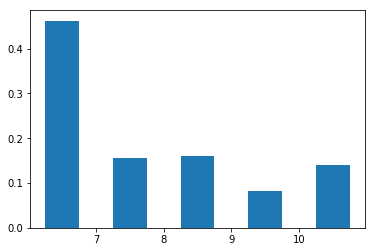

In [16]:
# distribution of patients over the number of visits
visits_pat=diagfeat_EADL.groupby('PATNO').size()
visits_pat.sort_values(ascending=False)
plt.hist(x=visits_pat,bins=list(set(visits_pat.values)),normed=True,rwidth=0.5)

## 2-Plotting. 

### Features

In [17]:
# simple Matplotlib graph
df_3051=diagfeat_EADL.loc[diagfeat_EADL['PATNO']==3051,:]
#plt.plot(df_3051['INFODT'], df_3051['MSEADLG'])
#plt.show()

In [18]:
import cufflinks as cf
# Configure it to work offline:
cf.go_offline(connected=True)

df_3051=diagfeat_EADL.loc[diagfeat_EADL['PATNO']==3051,:]
df_3051.set_index('INFODT',inplace=True)
df_3051['var_sumfeat']=df_3051.iloc[:,range(3,54)].sum(axis=1)
df_3051_sumfeat=df_3051.loc[:,'var_sumfeat']
df_3051_plot=df_3051.iloc[:,range(3,54)]

df_3051_plot.iplot(kind='scatter',filename='PATNO 3051 Diag Feat over time',mode='lines+markers')
#find something better than scatter plot.

In [19]:
# Plotting the labels of multiple patients
sub_df=patients_sampling(diagfeat_EADL)
sub_df['INFODT_date']=sub_df['INFODT'].apply(lambda x: datetime.strptime(x,'%m/%Y'))

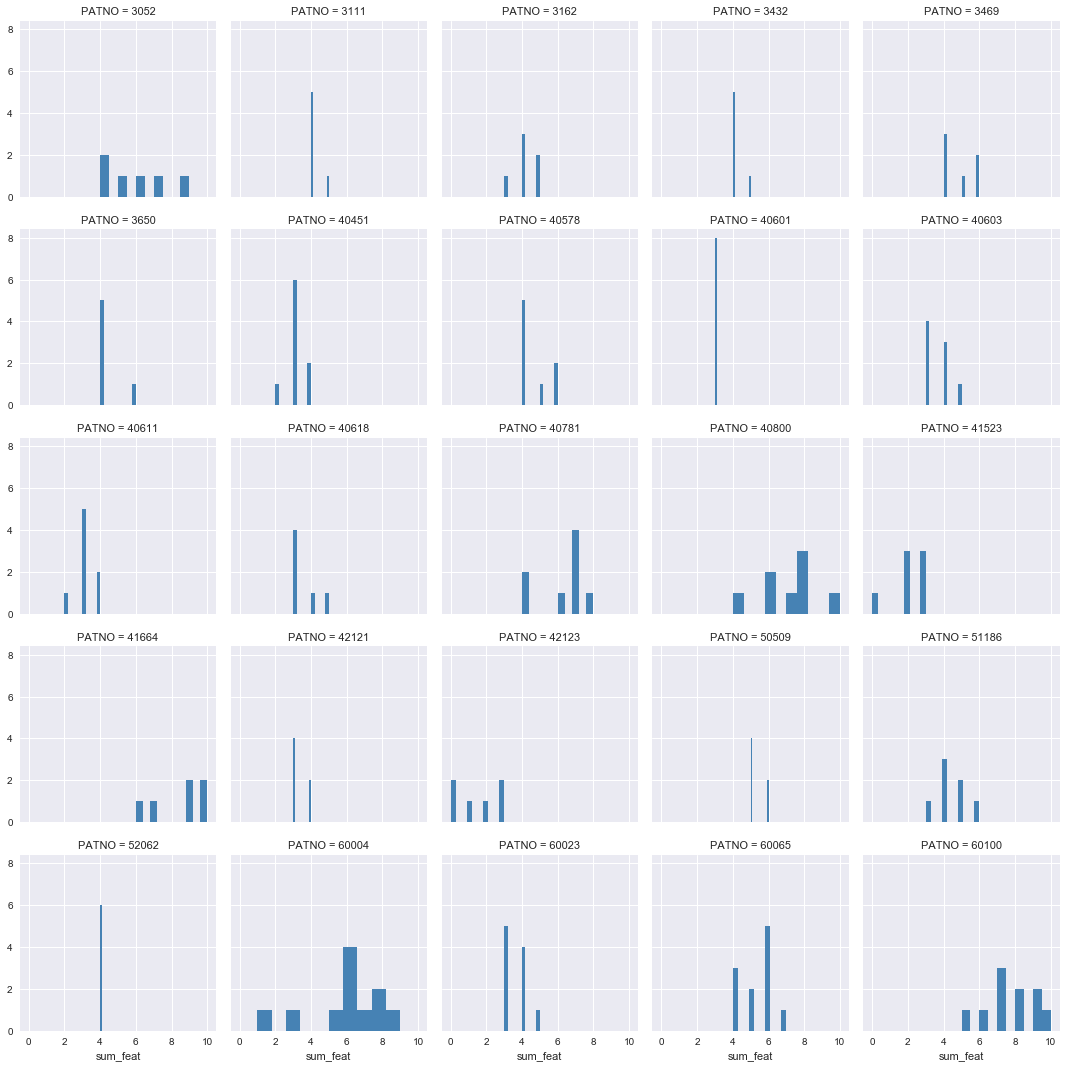

In [20]:
# https://seaborn.pydata.org/examples/faceted_histogram.html
sns.set(style="darkgrid")
g = sns.FacetGrid(sub_df, col="PATNO", margin_titles=True,col_wrap=5)
g.map(plt.hist, "sum_feat", color="steelblue")

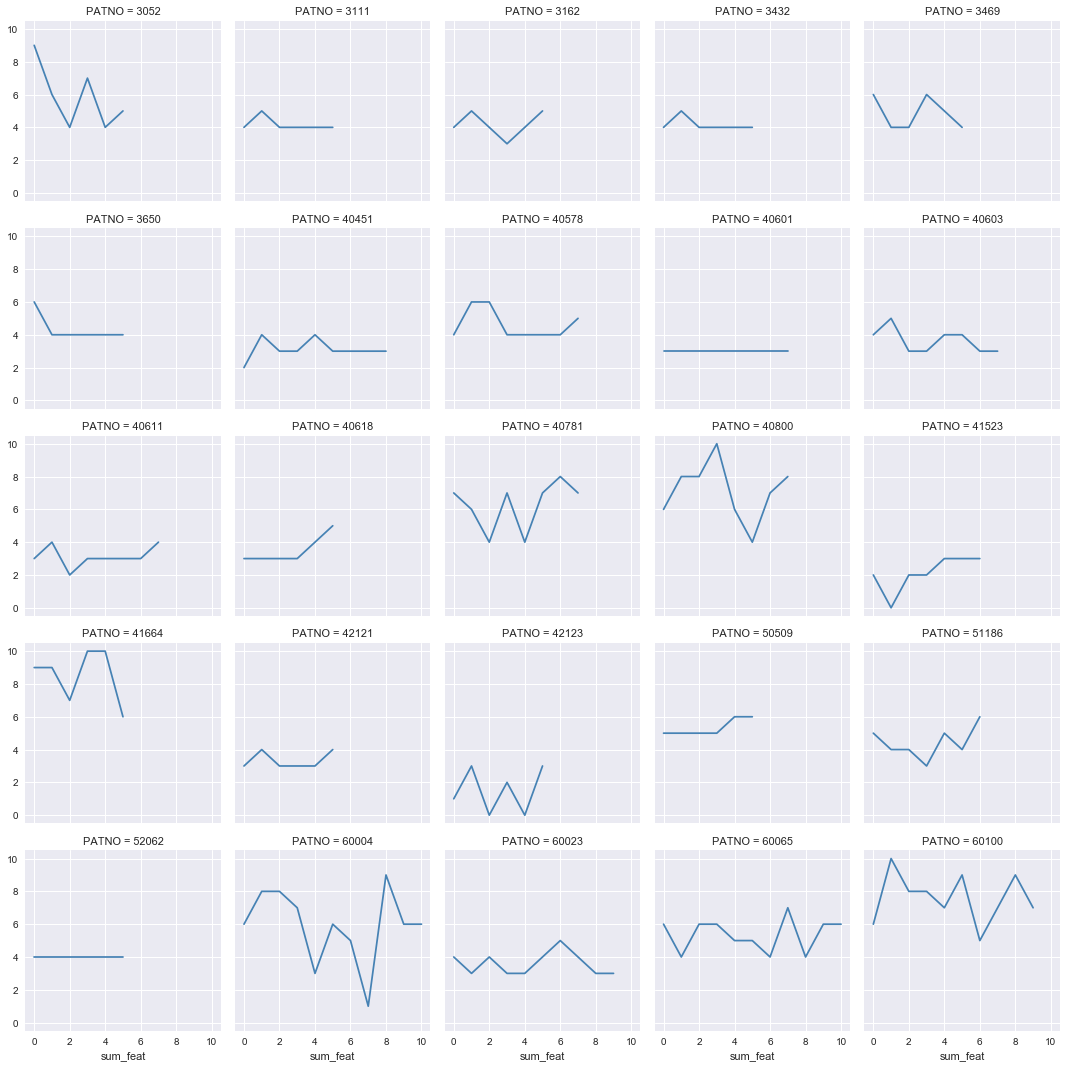

In [21]:
sns.set(style="darkgrid")
g = sns.FacetGrid(sub_df, col="PATNO", margin_titles=True,col_wrap=5)
#bins = np.linspace(0, 60, 13)
g.map(plt.plot, "sum_feat", color="steelblue")

In [37]:
#fig,ax=plt.plot()
#ax = sns.stripplot(x="PATNO", y="sum_feat",data=sub_df, jitter=True)
#ax.figure.set_size_inches(w=20,h=10)
#plt.show()

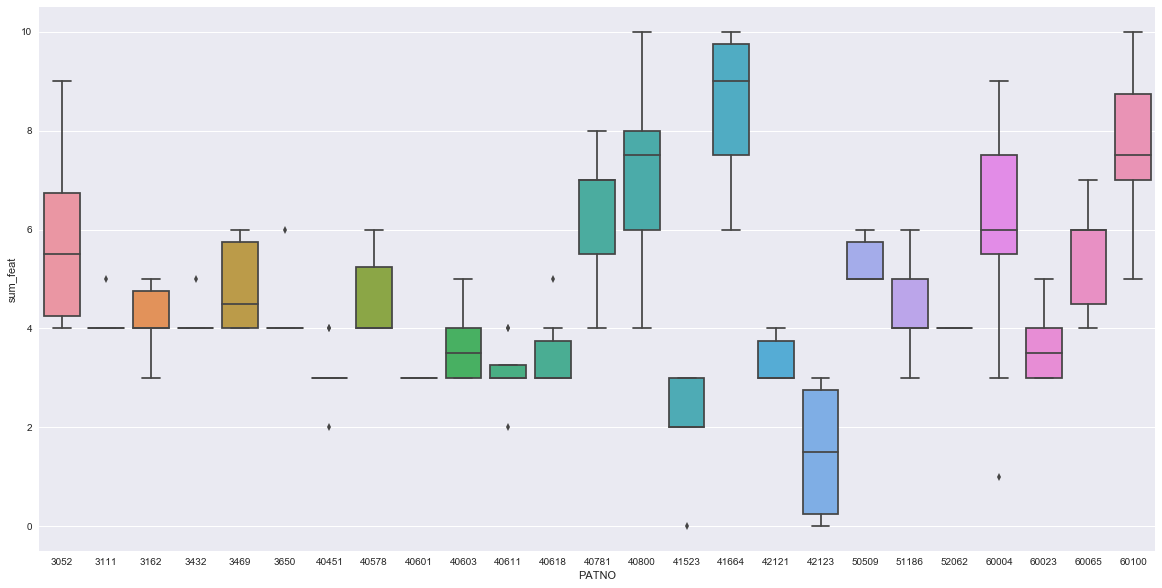

In [23]:
ax=sns.boxplot(y="sum_feat",
            x="PATNO", data=sub_df)
ax.figure.set_size_inches(w=20,h=10)

### Labels

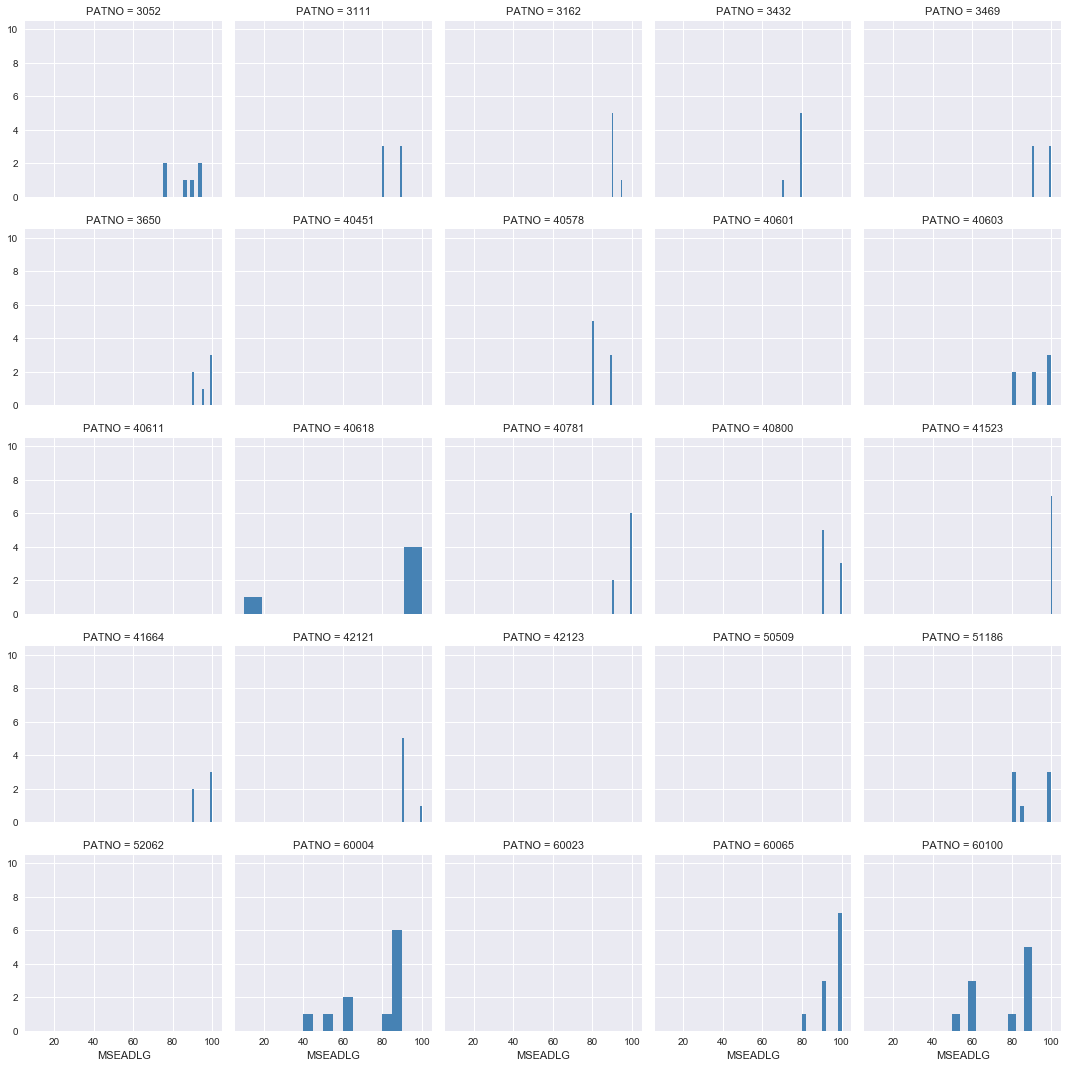

In [24]:
# https://seaborn.pydata.org/examples/faceted_histogram.html
sns.set(style="darkgrid")
g = sns.FacetGrid(sub_df, col="PATNO", margin_titles=True, col_wrap=5)
g.map(plt.hist, "MSEADLG", color="steelblue")

# ADD TITLE

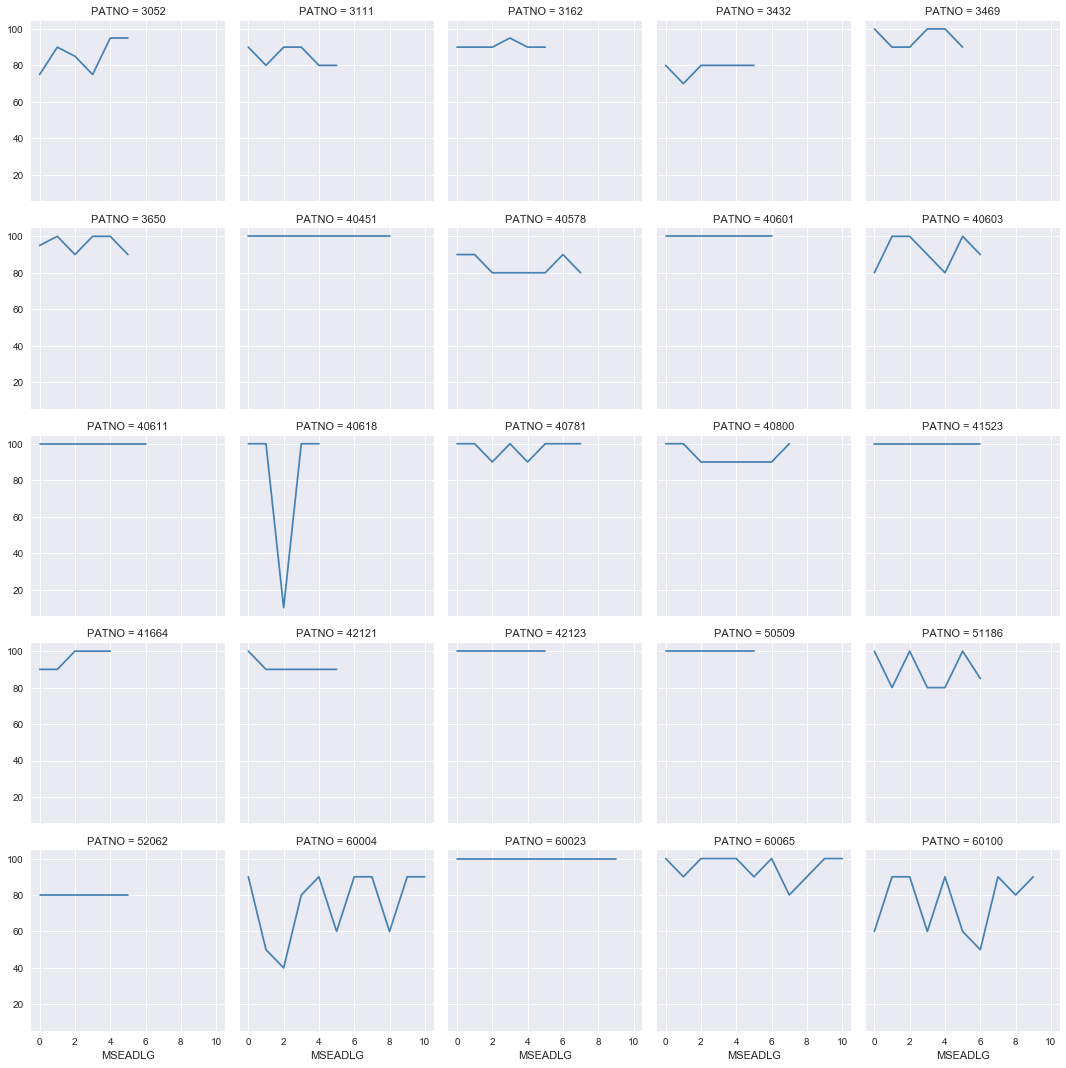

In [25]:
sns.set(style="darkgrid")
g = sns.FacetGrid(sub_df, col="PATNO", margin_titles=True,col_wrap=5)
g.map(plt.plot, "MSEADLG", color="steelblue")

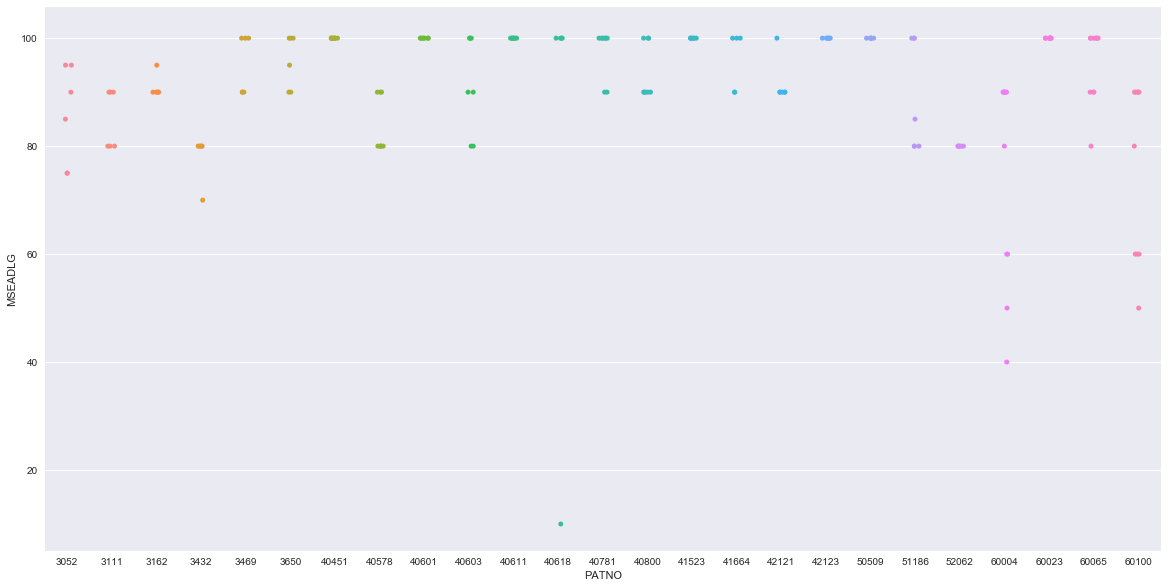

In [26]:
ax = sns.stripplot(x="PATNO", y="MSEADLG",data=sub_df, jitter=True)
ax.figure.set_size_inches(w=20,h=10)
plt.show()

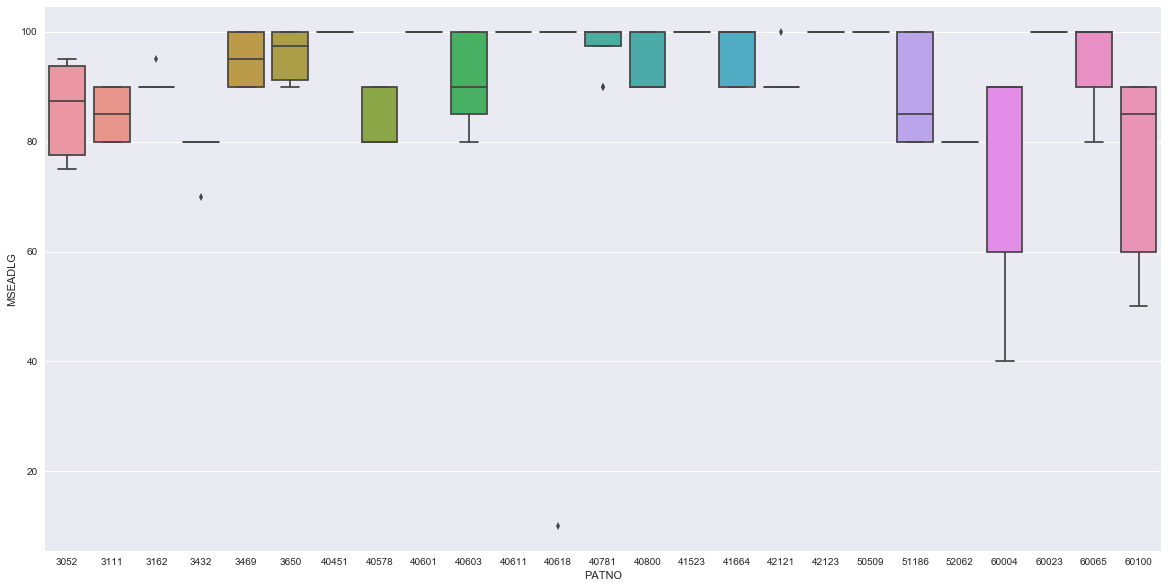

In [27]:
ax=sns.boxplot(y="MSEADLG",
            x="PATNO", data=sub_df)
ax.figure.set_size_inches(w=20,h=10)

## TO USE LATER ON (multi-label classification)

In [35]:
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/6-Motor-Assessments/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### 'MDS_UPDRS_Part_I.csv' - 2010 patients
NUPDRS1=dict_files[files_names[2]]
print(number_of_patients(NUPDRS1))
NUPDRS1=INFODT_date(NUPDRS1)
NUPDRS1.columns
NUPDRS1['sum_feat']=NUPDRS1[['NP1COG', 'NP1HALL', 'NP1DPRS', 'NP1ANXS', 'NP1APAT',
       'NP1DDS']].sum(axis=1)
NUPDRS1.head()

(2010, 20)


,REC_ID,F_STATUS,PATNO,EVENT_ID,PAG_NAME,INFODT,NUPSOURC,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,ORIG_ENTRY,LAST_UPDATE,QUERY,SITE_APRV,INFODT_date,sum_feat
0,231798601,V,3402,SC,NUPDRS1,07/2010,1.0,0.0,0.0,1.0,0.0,2.0,0.0,07/2010,2010-07-09 12:00:30.0,NaN,07/2010,2010-07-01,3.0
1,233164301,V,3400,BL,NUPDRS1,07/2010,1.0,0.0,0.0,2.0,3.0,2.0,0.0,07/2010,2010-07-15 17:04:33.0,NaN,07/2010,2010-07-01,7.0
2,230955201,V,3403,SC,NUPDRS1,07/2010,1.0,0.0,0.0,0.0,0.0,0.0,0.0,07/2010,2010-07-06 13:03:54.0,NaN,07/2010,2010-07-01,0.0
3,234837501,V,3404,BL,NUPDRS1,07/2010,1.0,0.0,0.0,0.0,0.0,0.0,0.0,07/2010,2010-07-23 11:30:12.0,NaN,07/2010,2010-07-01,0.0
4,232712901,V,3406,SC,NUPDRS1,07/2010,1.0,0.0,0.0,0.0,1.0,1.0,0.0,07/2010,2010-07-14 08:54:29.0,NaN,07/2010,2010-07-01,2.0


In [29]:
### 'MDS_UPDRS_Part_III.csv' - 2010 patients
NUPDRS3=dict_files[files_names[7]]
print(number_of_patients(NUPDRS3))
NUPDRS3.head()

(2010, 20)


,REC_ID,F_STATUS,PATNO,EVENT_ID,PAG_NAME,INFODT,CMEDTM,EXAMTM,NP3SPCH,NP3FACXP,...,DYSKPRES,DYSKIRAT,NHY,ANNUAL_TIME_BTW_DOSE_NUPDRS,ON_OFF_DOSE,PD_MED_USE,ORIG_ENTRY,LAST_UPDATE,QUERY,SITE_APRV
0,324141901,V,3506,V03,NUPDRS3,10/2011,NaN,NaN,1.0,1.0,...,0.0,NaN,1.0,NaN,NaN,0,12/2011,2011-12-05 19:23:15.0,NaN,12/2011
1,324180301,V,3419,V02,NUPDRS3,12/2011,NaN,NaN,0.0,0.0,...,0.0,NaN,1.0,NaN,NaN,0,12/2011,2011-12-06 07:25:10.0,NaN,12/2011
2,324389901,V,3816,BL,NUPDRS3,12/2011,NaN,NaN,0.0,0.0,...,0.0,NaN,0.0,NaN,NaN,0,12/2011,2011-12-07 02:10:18.0,NaN,12/2011
3,324396501,V,3762,BL,NUPDRS3,11/2011,NaN,NaN,0.0,1.0,...,1.0,1.0,2.0,NaN,NaN,0,12/2011,2011-12-07 02:34:41.0,NaN,12/2011
4,324399901,V,3765,BL,NUPDRS3,11/2011,NaN,NaN,0.0,0.0,...,0.0,NaN,0.0,NaN,NaN,0,12/2011,2011-12-07 02:47:42.0,NaN,12/2011


In [30]:
### 'General_Neurological_Exam.csv': useful: Feat-Gen - 2048 patients
PENEURO=dict_files[files_names[7]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'MSRARSP', 'MSRACM', 'MSLARSP', 'MSLACM', 'MSRLRSP', 'MSRLCM',
       'MSLLRSP', 'MSLLCM', 'COFNRRSP', 'COFNRCM', 'COFNLRSP', 'COFNLCM',
       'COHSRRSP', 'COHSRCM', 'COHSLRSP', 'COHSLCM', 'SENRARSP', 'SENRACM',
       'SENLARSP', 'SENLACM', 'SENRLRSP', 'SENRLCM', 'SENLLRSP', 'SENLLCM',
       'RFLRARSP', 'RFLRACM', 'RFLLARSP', 'RFLLACM', 'RFLRLRSP', 'RFLRLCM',
       'RFLLLRSP', 'RFLLLCM', 'PLRRRSP', 'PLRRCM', 'PLRLRSP', 'PLRLCM']
print(number_of_patients(PENEURO))
PENEURO_sel=PENEURO[SEL]
PENEURO_sel.head()
#list(set(PENEURO['EVENT_ID']))

### 'Neurological_Exam_-_Cranial_Nerves.csv': useful: Feat-PD - 2049 patients

PENEURO2=dict_files[files_names[13]]
PENEURO2.head()
PENEURO2.columns

SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'CN1RSP','CN2RSP', 'CN346RSP','CN5RSP',
     'CN7RSP', 'CN8RSP', 'CN910RSP',
       'CN11RSP', 'CN12RSP']
print(number_of_patients(PENEURO2))
PENEURO2_sel=PENEURO2[SEL]
PENEURO2_sel.head()
#list(set(PENEURO['EVENT_ID']))

(2010, 20)


KeyError: "['MSRARSP' 'MSRACM' 'MSLARSP' 'MSLACM' 'MSRLRSP' 'MSRLCM' 'MSLLRSP'\n 'MSLLCM' 'COFNRRSP' 'COFNRCM' 'COFNLRSP' 'COFNLCM' 'COHSRRSP' 'COHSRCM'\n 'COHSLRSP' 'COHSLCM' 'SENRARSP' 'SENRACM' 'SENLARSP' 'SENLACM' 'SENRLRSP'\n 'SENRLCM' 'SENLLRSP' 'SENLLCM' 'RFLRARSP' 'RFLRACM' 'RFLLARSP' 'RFLLACM'\n 'RFLRLRSP' 'RFLRLCM' 'RFLLLRSP' 'RFLLLCM' 'PLRRRSP' 'PLRRCM' 'PLRLRSP'\n 'PLRLCM'] not in index"

In [ ]:
### 'Vital_Signs.csv': useful: Feat-Gen
### 2047 patients

VITAL=dict_files[files_names[15]]
#VITAL.head()
#VITAL.columns

SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'WGTKG', 'HTCM', 'TEMPC', 'SYSSUP', 'DIASUP', 'HRSUP',
       'SYSSTND', 'DIASTND', 'HRSTND']
print(number_of_patients(VITAL))
VITAL_sel=VITAL[SEL]
VITAL_sel.head()

### Plotly code bugging: understand why.

#plotting with plotly 
import plotly as py
py.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

#Traces
data=[]
for i in patients_sample: 
    sub_df=diagfeat_EADL.loc[diagfeat_EADL['PATNO']==i,:]
    sub_df['INFODT_date']=sub_df['INFODT'].apply(lambda x: datetime.strptime(x,'%m/%Y'))
    #print(len(sub_df))
    sub_df.dropna(inplace=True)
    #trace=dict(type='scatter',x=sub_df['INFODT'],
              # y=sub_df['MSEADLG'],
              # name='PATNO{}'.format(i))
    trace=go.Scatter(x=sub_df['INFODT_date'],y=sub_df['MSEADLG'],name='PATNO{}'.format(i))
    data.append(trace)
#Figure
#fig=go.Figure(data)